In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from optbinning import OptimalBinning
from sklearn.tree import DecisionTreeClassifier
from natsort import natsorted
import src.metrics as metrics
from src.binning import *

(CVXPY) Feb 26 05:26:08 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 26 05:26:08 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [8]:
df = pd.read_csv(r"C:\Users\ruben\OneDrive\Desktop\Loan approvval\default_dataset.csv")

for col in df.columns:
    if df[col].isna().sum() > 0:
        print(f"Column {col} has {df[col].isna().sum()} missing values")
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].median())
        else:
            df[col] = df[col].fillna(df[col].mode()[0])

#df = df.loc[(df['person_age'] < 100) & (df['person_income'] < 250000)]
df.head()

Column person_emp_length has 895 missing values
Column loan_int_rate has 3116 missing values


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [9]:
features = ['person_income', 'loan_int_rate']
binned_df, bin_stats, bin_labels = create_multivariate_binned_feature(
    df, 
    features, 
    'loan_status', 
    max_leaf_nodes=8,
    min_samples_leaf=0.05
)

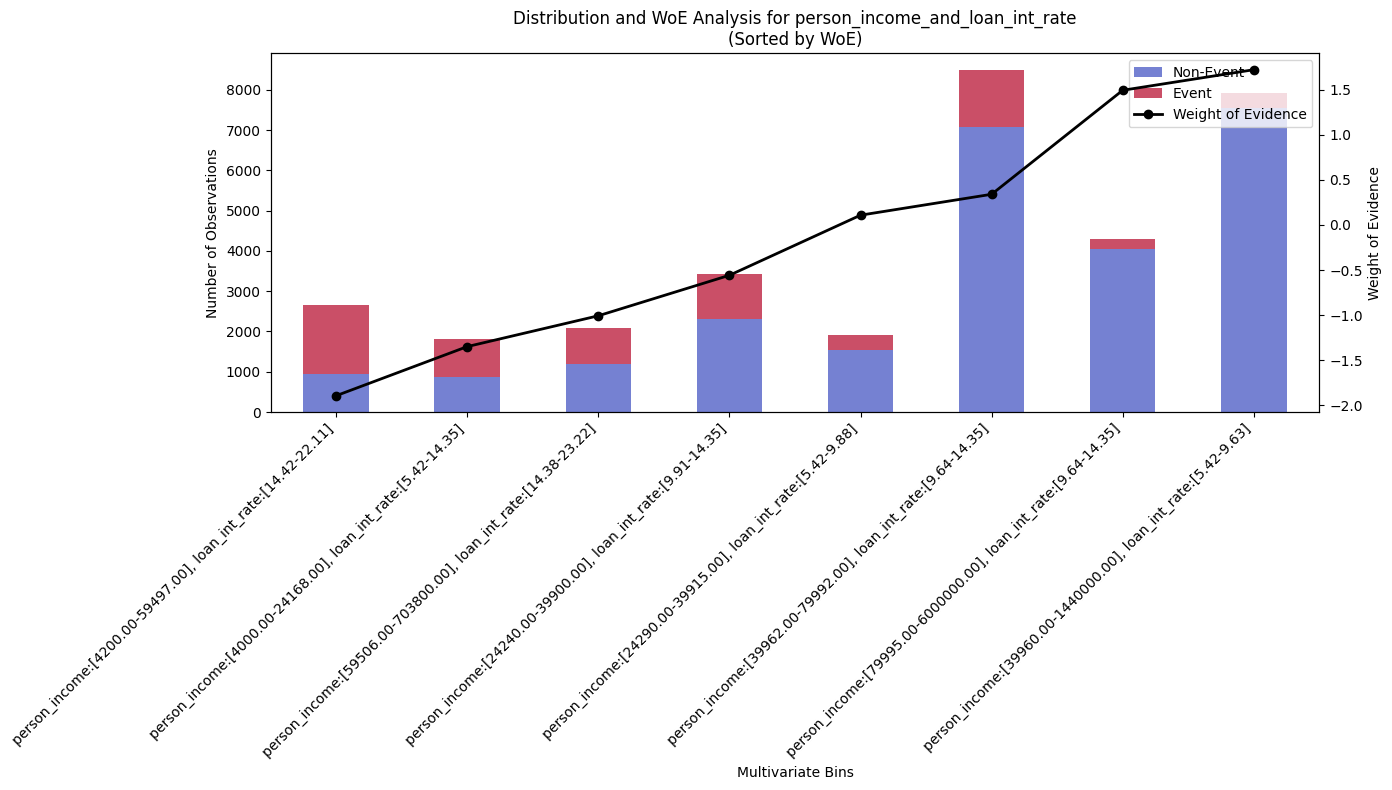

In [10]:
woe_df, woe_summary, total_iv = calculate_multivariate_woe(
        binned_df,
        features,
        'loan_status',
        plot=True
)

In [11]:
total_iv

1.2708508719099878

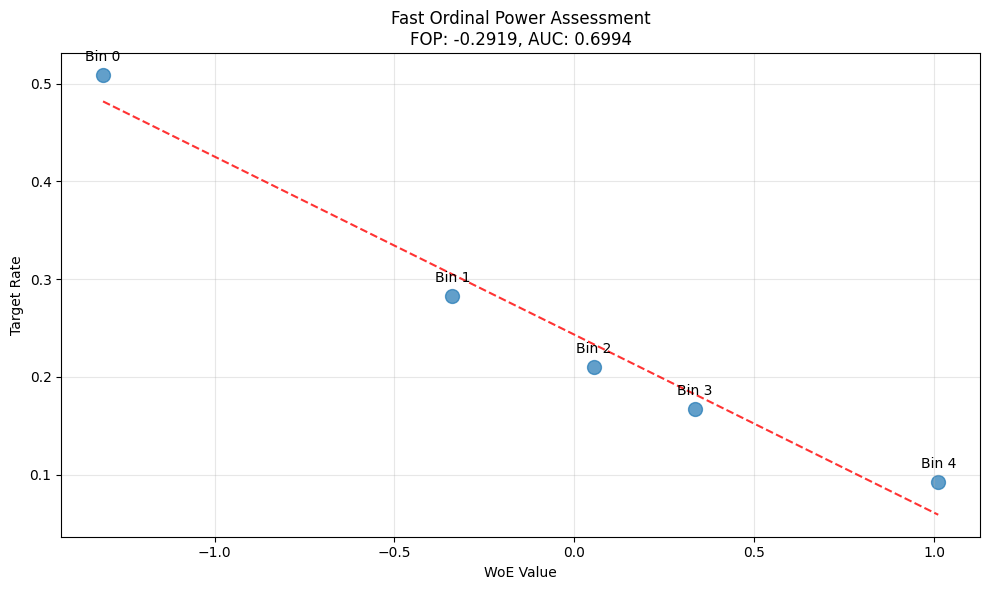

Fast Ordinal Power score: -0.2919
AUC score: 0.6994
Information Value: 0.5888


In [5]:
# Now assess the performance using Fast Ordinal Power
combined_feature_name = "_and_".join(features)
fop_score, auc_score = calculate_fast_ordinal_power(
    woe_df, 
    f'{combined_feature_name}_woe',  # This should match the WoE column name created by calculate_multivariate_woe
    'loan_status',
    plot=True  # Set to True to see the visualization
)

print(f"Fast Ordinal Power score: {fop_score:.4f}")
print(f"AUC score: {auc_score:.4f}")
print(f"Information Value: {total_iv:.4f}")

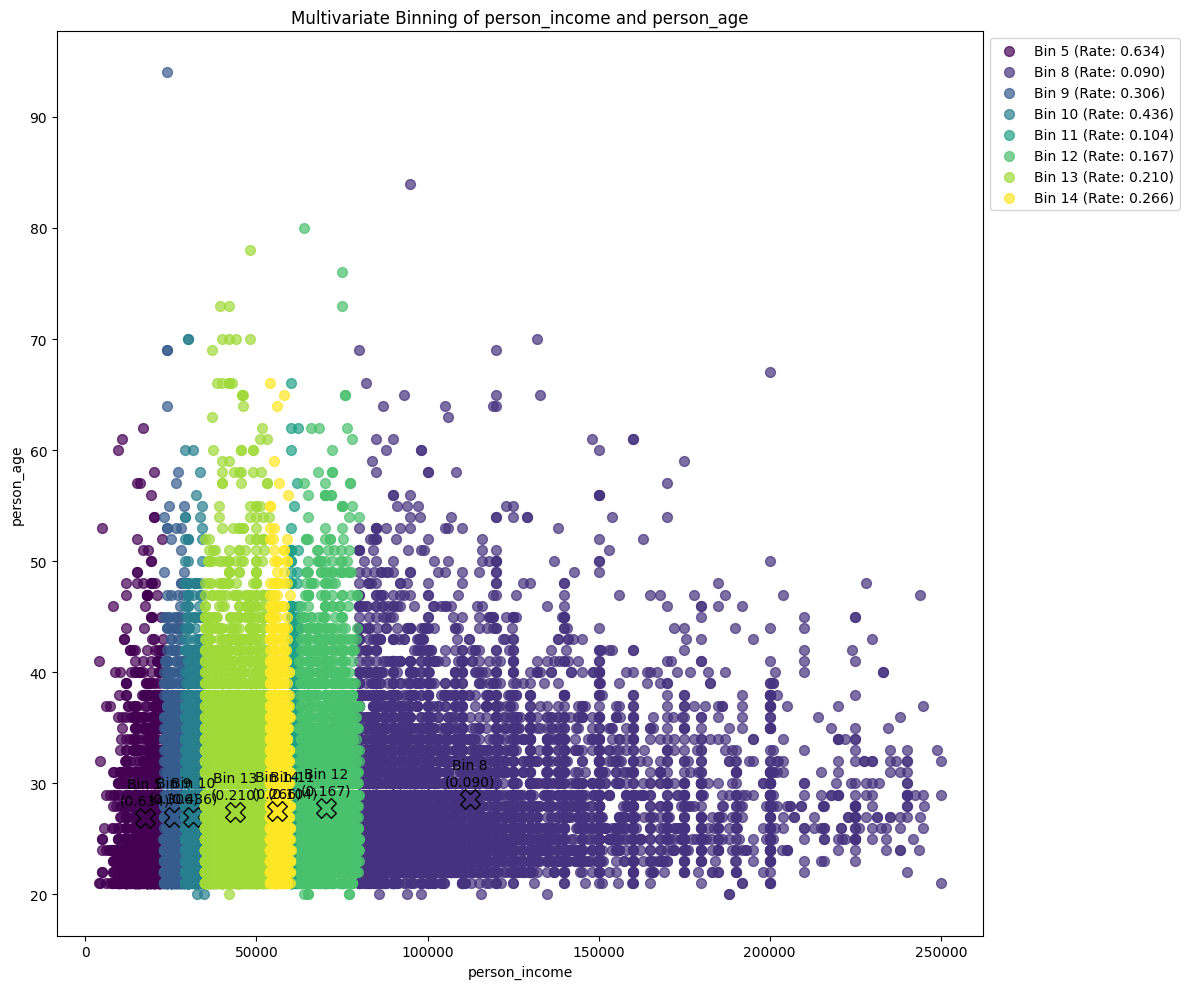

In [10]:
visualize_multivariate_bins(
        binned_df,
        features,
        'loan_status',
        'person_income_and_person_age_bin',
        bin_stats
    )

### Explore binning options

#### Decision tree for binning

##### Deicide on maximum number of bins for each variable

In [31]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['person_age']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.5174 ± 0.0163
Max leaf nodes:  3, ROC AUC: 0.5095 ± 0.0151
Max leaf nodes:  4, ROC AUC: 0.5095 ± 0.0152
Max leaf nodes:  5, ROC AUC: 0.5095 ± 0.0152
Max leaf nodes:  6, ROC AUC: 0.5097 ± 0.0150
Max leaf nodes:  7, ROC AUC: 0.5094 ± 0.0138
Max leaf nodes:  8, ROC AUC: 0.5082 ± 0.0135
Max leaf nodes:  9, ROC AUC: 0.5103 ± 0.0132
Max leaf nodes: 10, ROC AUC: 0.5105 ± 0.0128

Best max_leaf_nodes: 2 with ROC AUC: 0.5174


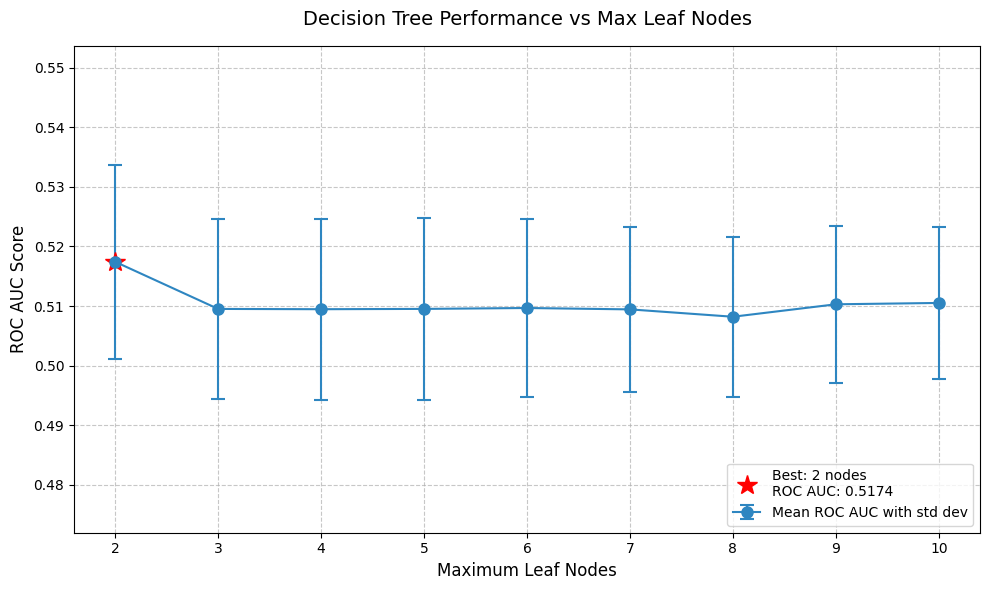

In [ ]:
plot_tree_performance(all_results)

##### Binning of variable

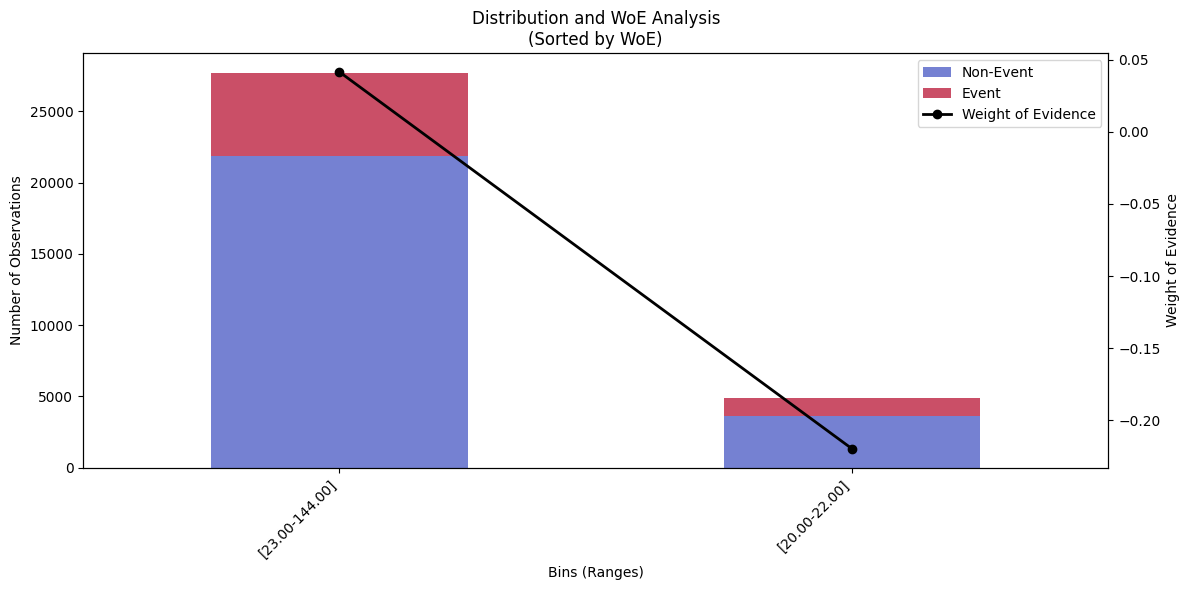

In [33]:
df, bin_stats, bin_labels = create_binned_feature(df, 'person_age', 'loan_status', max_leaf_nodes=2)
df, woe_summary, iv = calculate_woe(df, 'person_age', 'loan_status', plot=True, bin_labels=bin_labels)

#### Person income

In [37]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['person_income']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.6249 ± 0.0550
Max leaf nodes:  3, ROC AUC: 0.6537 ± 0.0563
Max leaf nodes:  4, ROC AUC: 0.6596 ± 0.0513
Max leaf nodes:  5, ROC AUC: 0.6855 ± 0.0599
Max leaf nodes:  6, ROC AUC: 0.6766 ± 0.0543
Max leaf nodes:  7, ROC AUC: 0.6854 ± 0.0533
Max leaf nodes:  8, ROC AUC: 0.6943 ± 0.0653
Max leaf nodes:  9, ROC AUC: 0.6866 ± 0.0582
Max leaf nodes: 10, ROC AUC: 0.6912 ± 0.0639

Best max_leaf_nodes: 8 with ROC AUC: 0.6943


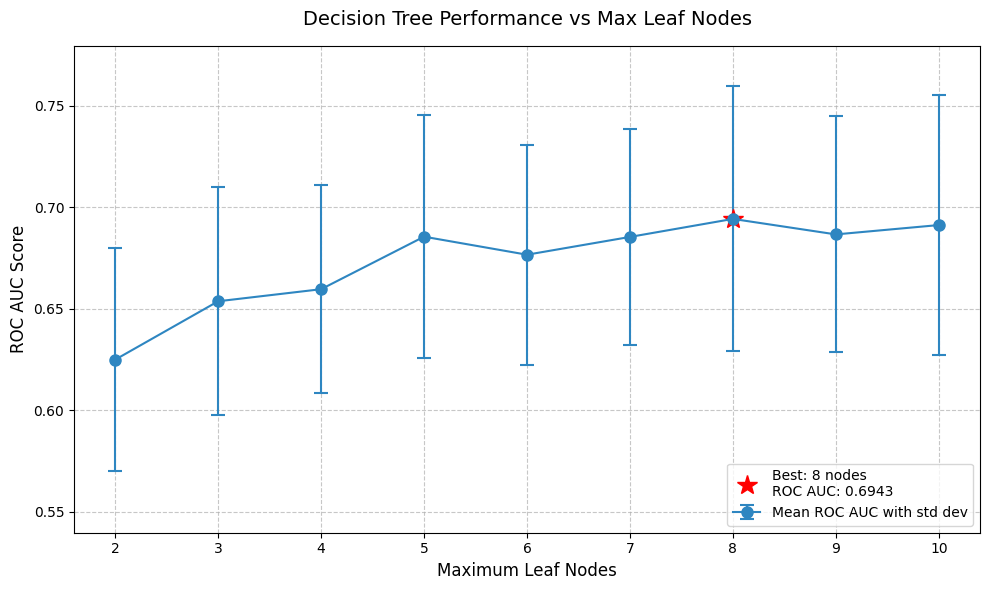

In [38]:
plot_tree_performance(all_results)

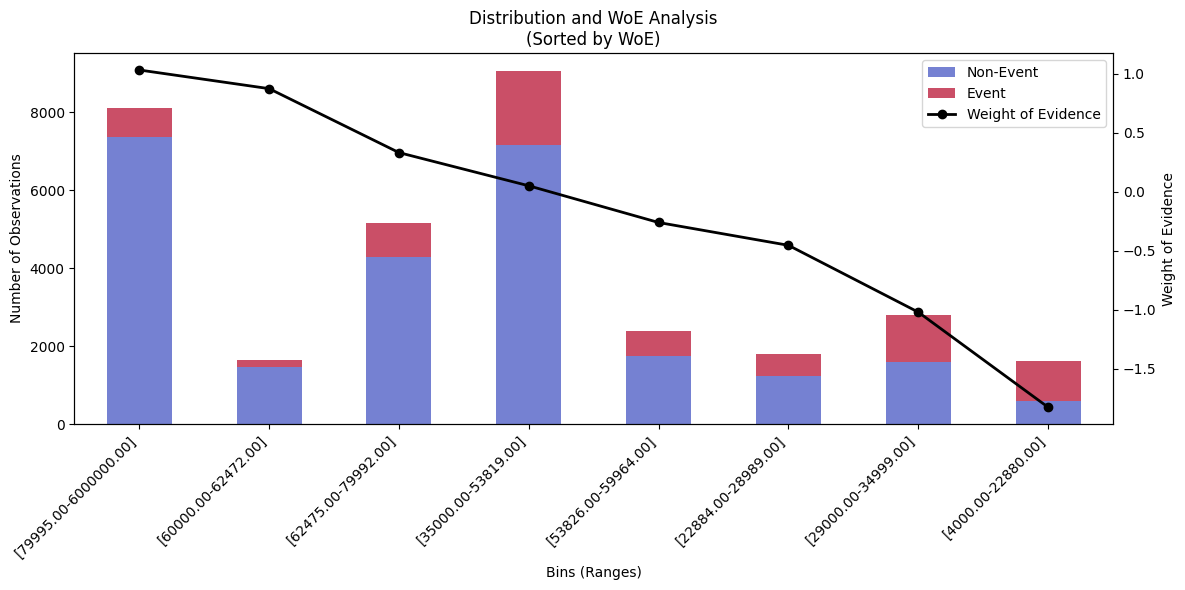

In [39]:
df, bin_stats, bin_labels = create_binned_feature(df, 'person_income', 'loan_status', max_leaf_nodes=8)
df, woe_summary, iv = calculate_woe(df, 'person_income', 'loan_status', plot=True, bin_labels=bin_labels)

#### Person employment length

In [42]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['person_emp_length']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.5485 ± 0.0138
Max leaf nodes:  3, ROC AUC: 0.5633 ± 0.0164
Max leaf nodes:  4, ROC AUC: 0.5642 ± 0.0165
Max leaf nodes:  5, ROC AUC: 0.5655 ± 0.0169
Max leaf nodes:  6, ROC AUC: 0.5674 ± 0.0173
Max leaf nodes:  7, ROC AUC: 0.5689 ± 0.0187
Max leaf nodes:  8, ROC AUC: 0.5683 ± 0.0189
Max leaf nodes:  9, ROC AUC: 0.5683 ± 0.0193
Max leaf nodes: 10, ROC AUC: 0.5683 ± 0.0193

Best max_leaf_nodes: 7 with ROC AUC: 0.5689


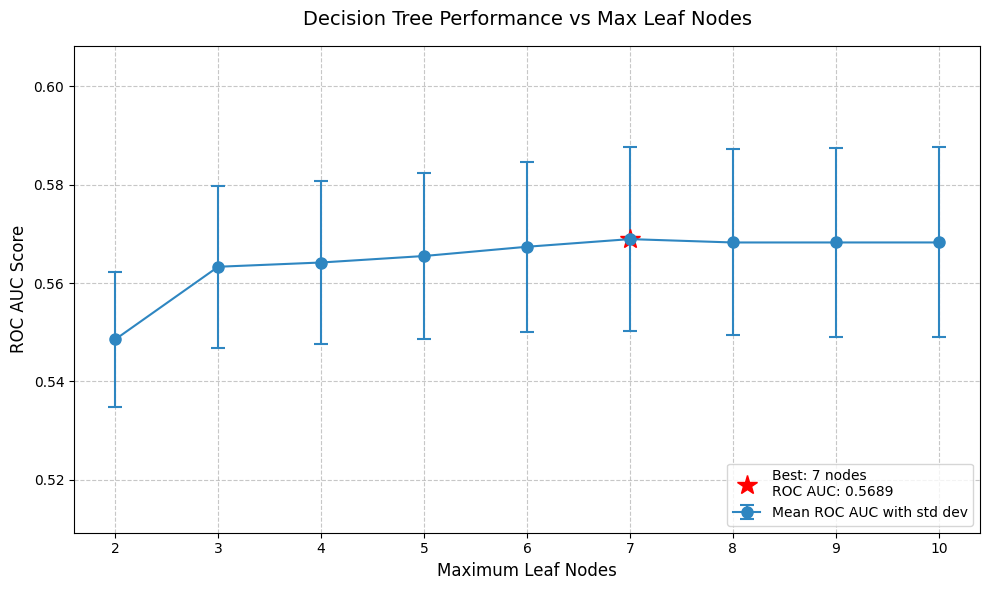

In [43]:
plot_tree_performance(all_results)

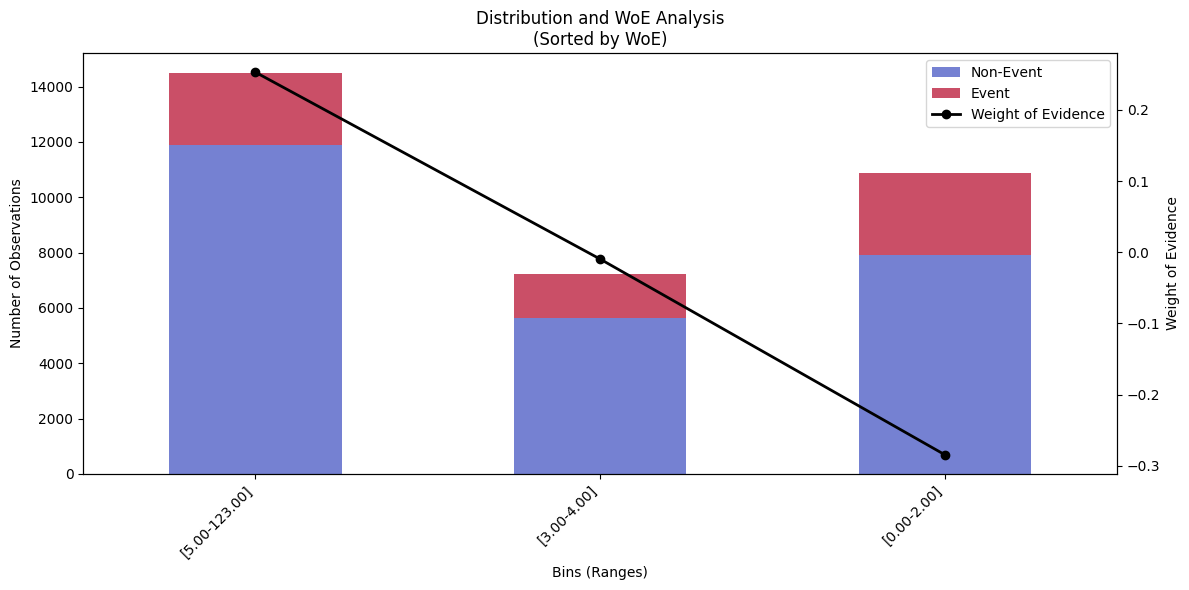

In [45]:
df, bin_stats, bin_labels = create_binned_feature(df, 'person_emp_length', 'loan_status', max_leaf_nodes=3)
df, woe_summary, iv = calculate_woe(df, 'person_emp_length', 'loan_status', plot=True, bin_labels=bin_labels)

#### Loan amount

In [47]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['loan_amnt']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.5297 ± 0.0731
Max leaf nodes:  3, ROC AUC: 0.5243 ± 0.0888
Max leaf nodes:  4, ROC AUC: 0.5426 ± 0.0899
Max leaf nodes:  5, ROC AUC: 0.5346 ± 0.1070
Max leaf nodes:  6, ROC AUC: 0.5315 ± 0.1051
Max leaf nodes:  7, ROC AUC: 0.5197 ± 0.0938
Max leaf nodes:  8, ROC AUC: 0.5187 ± 0.0936
Max leaf nodes:  9, ROC AUC: 0.5244 ± 0.0982
Max leaf nodes: 10, ROC AUC: 0.5281 ± 0.0954

Best max_leaf_nodes: 4 with ROC AUC: 0.5426


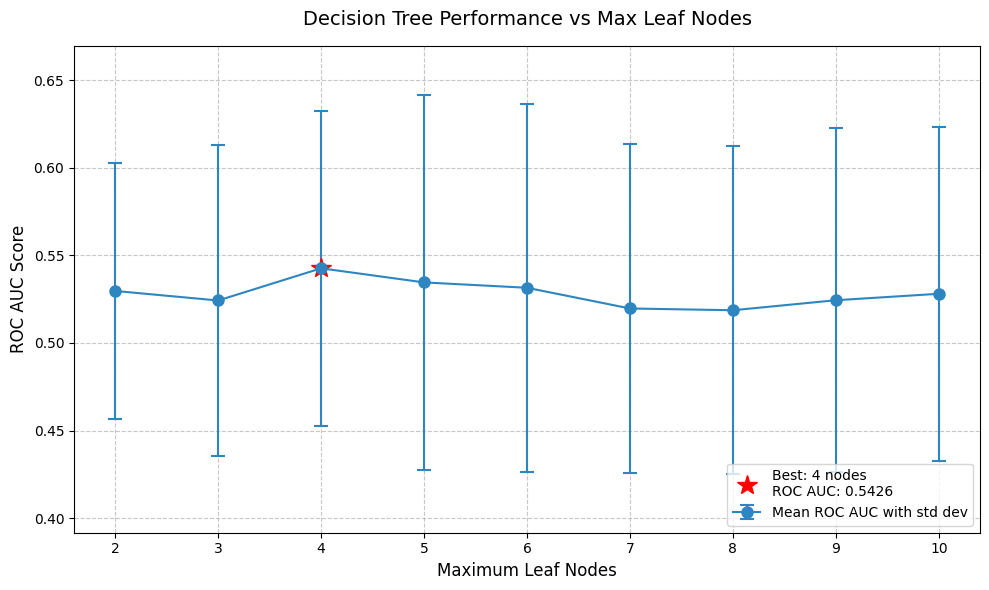

In [48]:
plot_tree_performance(all_results)

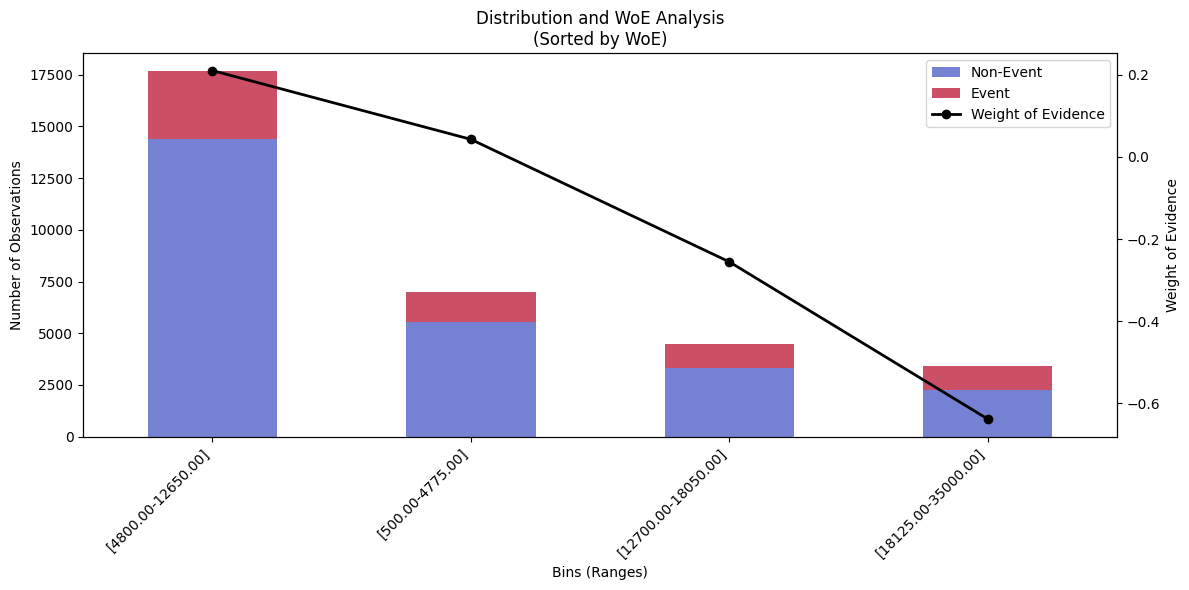

In [49]:
df, bin_stats, bin_labels = create_binned_feature(df, 'loan_amnt', 'loan_status', max_leaf_nodes=4)
df, woe_summary, iv = calculate_woe(df, 'loan_amnt', 'loan_status', plot=True, bin_labels=bin_labels)

#### Loan interest rate

In [51]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['loan_int_rate']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.6450 ± 0.0100
Max leaf nodes:  3, ROC AUC: 0.6901 ± 0.0103
Max leaf nodes:  4, ROC AUC: 0.6932 ± 0.0103
Max leaf nodes:  5, ROC AUC: 0.7009 ± 0.0114
Max leaf nodes:  6, ROC AUC: 0.7032 ± 0.0110
Max leaf nodes:  7, ROC AUC: 0.7053 ± 0.0112
Max leaf nodes:  8, ROC AUC: 0.7070 ± 0.0124
Max leaf nodes:  9, ROC AUC: 0.7078 ± 0.0124
Max leaf nodes: 10, ROC AUC: 0.7080 ± 0.0127

Best max_leaf_nodes: 10 with ROC AUC: 0.7080


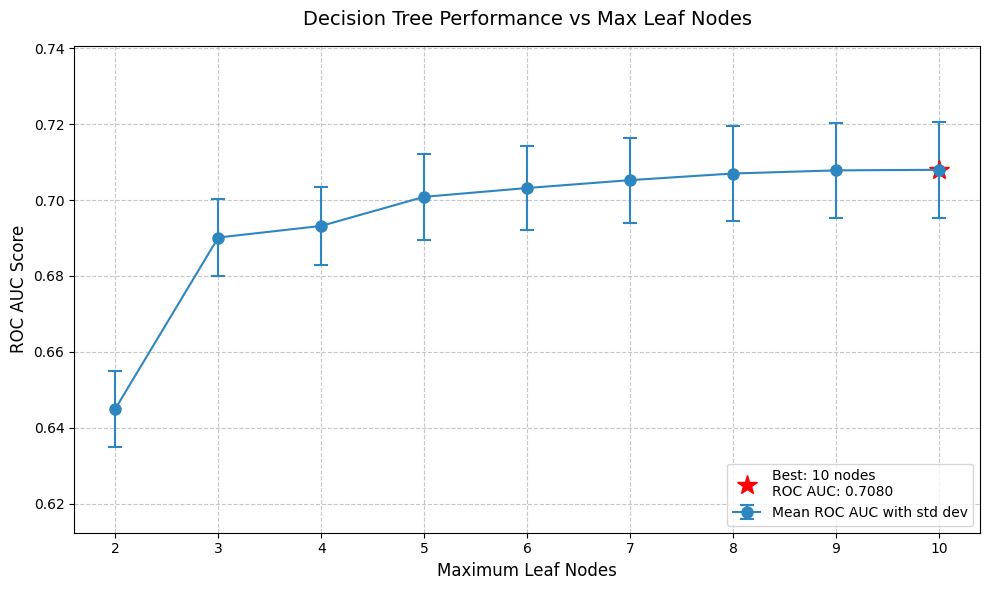

In [52]:
plot_tree_performance(all_results)

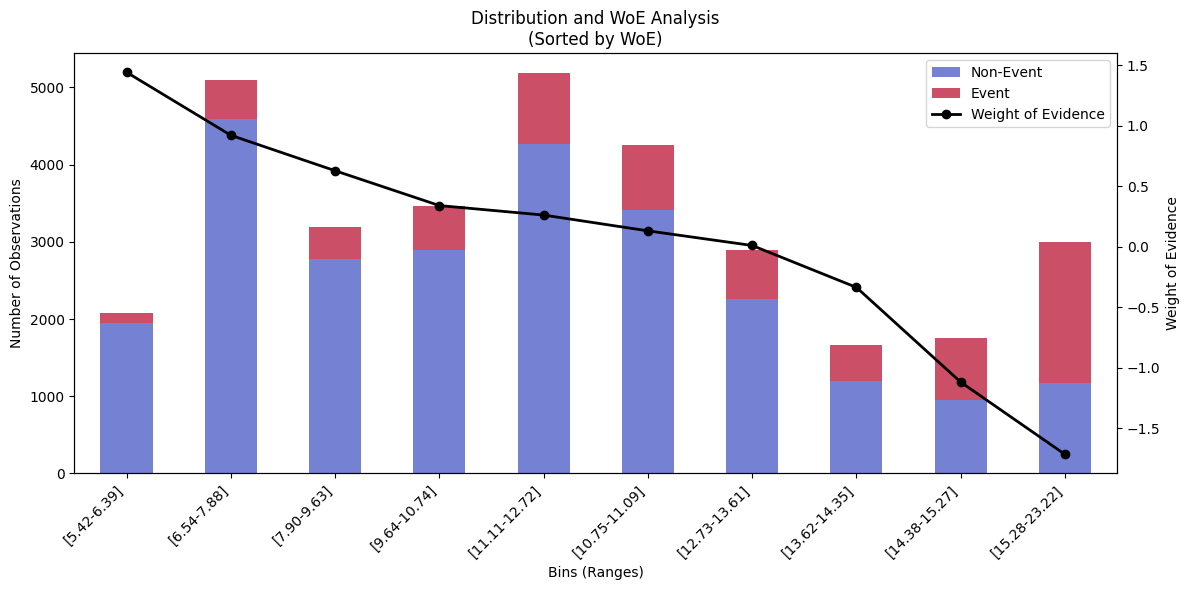

In [53]:
df, bin_stats, bin_labels = create_binned_feature(df, 'loan_int_rate', 'loan_status', max_leaf_nodes=10)
df, woe_summary, iv = calculate_woe(df, 'loan_int_rate', 'loan_status', plot=True, bin_labels=bin_labels)

#### Loan percent income

In [55]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['loan_percent_income']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.6673 ± 0.0261
Max leaf nodes:  3, ROC AUC: 0.7087 ± 0.0296
Max leaf nodes:  4, ROC AUC: 0.7131 ± 0.0294
Max leaf nodes:  5, ROC AUC: 0.7160 ± 0.0282
Max leaf nodes:  6, ROC AUC: 0.7167 ± 0.0296
Max leaf nodes:  7, ROC AUC: 0.7163 ± 0.0290
Max leaf nodes:  8, ROC AUC: 0.7160 ± 0.0287
Max leaf nodes:  9, ROC AUC: 0.7163 ± 0.0284
Max leaf nodes: 10, ROC AUC: 0.7163 ± 0.0283

Best max_leaf_nodes: 6 with ROC AUC: 0.7167


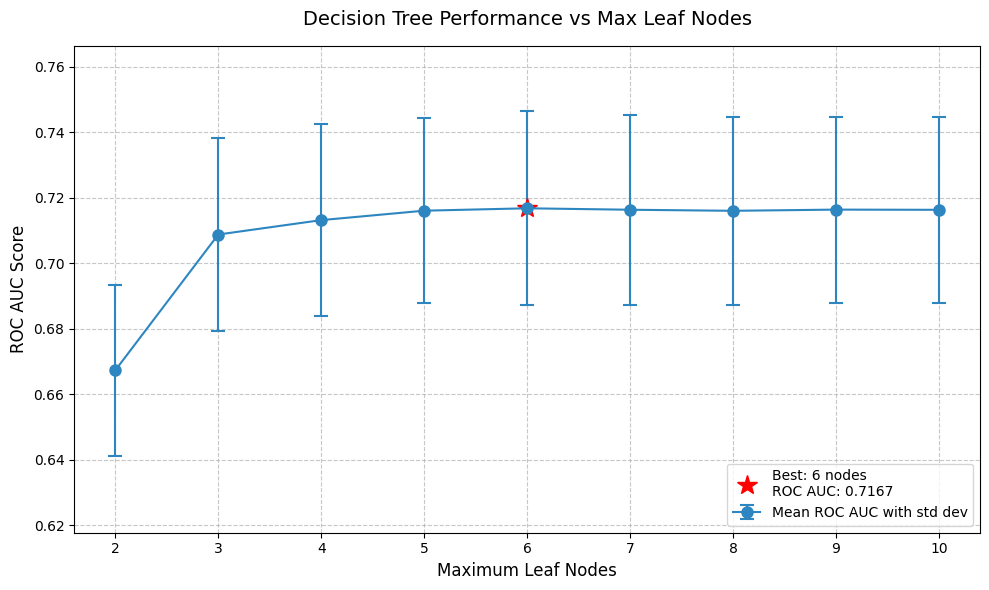

In [56]:
plot_tree_performance(all_results)

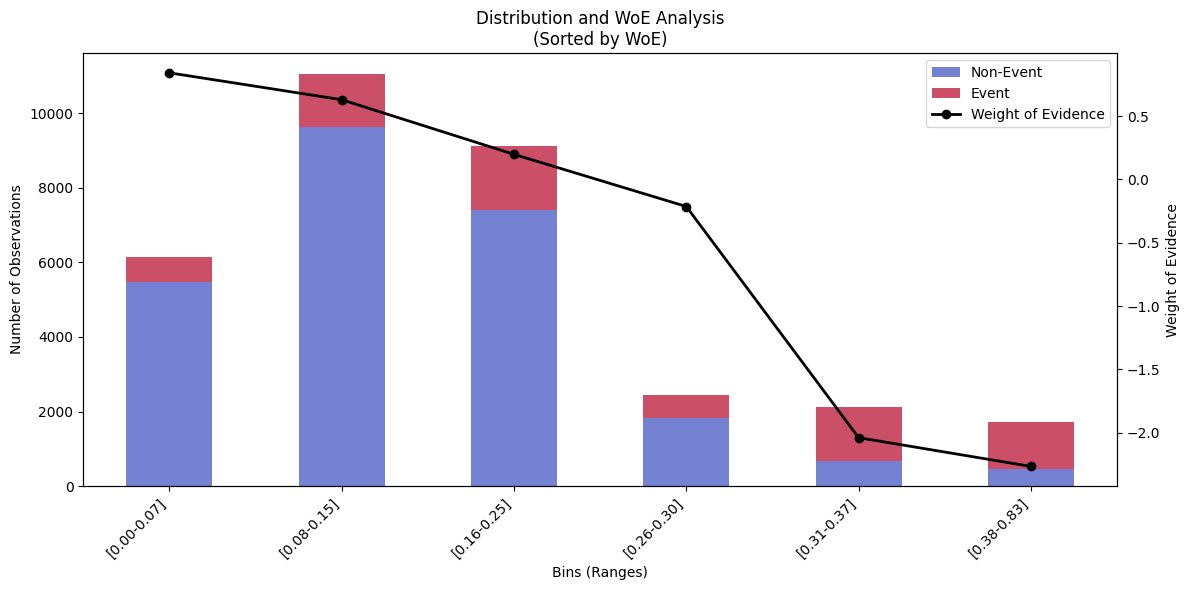

In [57]:
df, bin_stats, bin_labels = create_binned_feature(df, 'loan_percent_income', 'loan_status', max_leaf_nodes=6)
df, woe_summary, iv = calculate_woe(df, 'loan_percent_income', 'loan_status', plot=True, bin_labels=bin_labels)

#### cb_person_cred_hist_length

In [59]:
max_leaf_nodes_range = list(range(2, 11))
feature_columns = ['cb_person_cred_hist_length']
best_nodes, best_score, all_results = optimize_decision_tree_leaves(
    df,
    feature_columns,
    'loan_status',
    max_leaf_nodes_range
)


Results for different max_leaf_nodes values (ROC AUC):
Max leaf nodes:  2, ROC AUC: 0.5000 ± 0.0000
Max leaf nodes:  3, ROC AUC: 0.5094 ± 0.0147
Max leaf nodes:  4, ROC AUC: 0.4982 ± 0.0060
Max leaf nodes:  5, ROC AUC: 0.4937 ± 0.0113
Max leaf nodes:  6, ROC AUC: 0.4924 ± 0.0114
Max leaf nodes:  7, ROC AUC: 0.4923 ± 0.0115
Max leaf nodes:  8, ROC AUC: 0.4923 ± 0.0115
Max leaf nodes:  9, ROC AUC: 0.4921 ± 0.0112
Max leaf nodes: 10, ROC AUC: 0.4922 ± 0.0113

Best max_leaf_nodes: 3 with ROC AUC: 0.5094


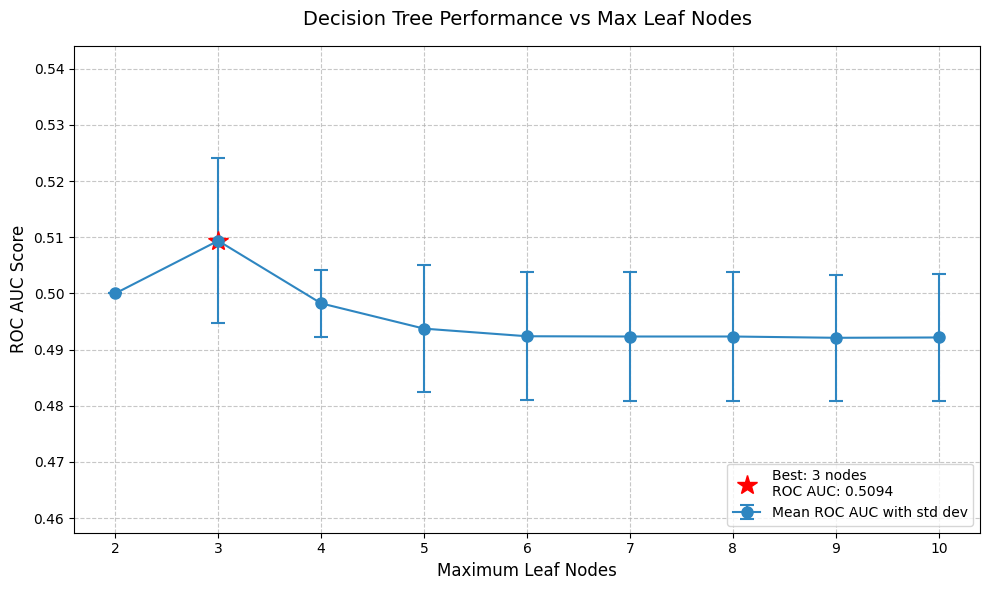

In [60]:
plot_tree_performance(all_results)

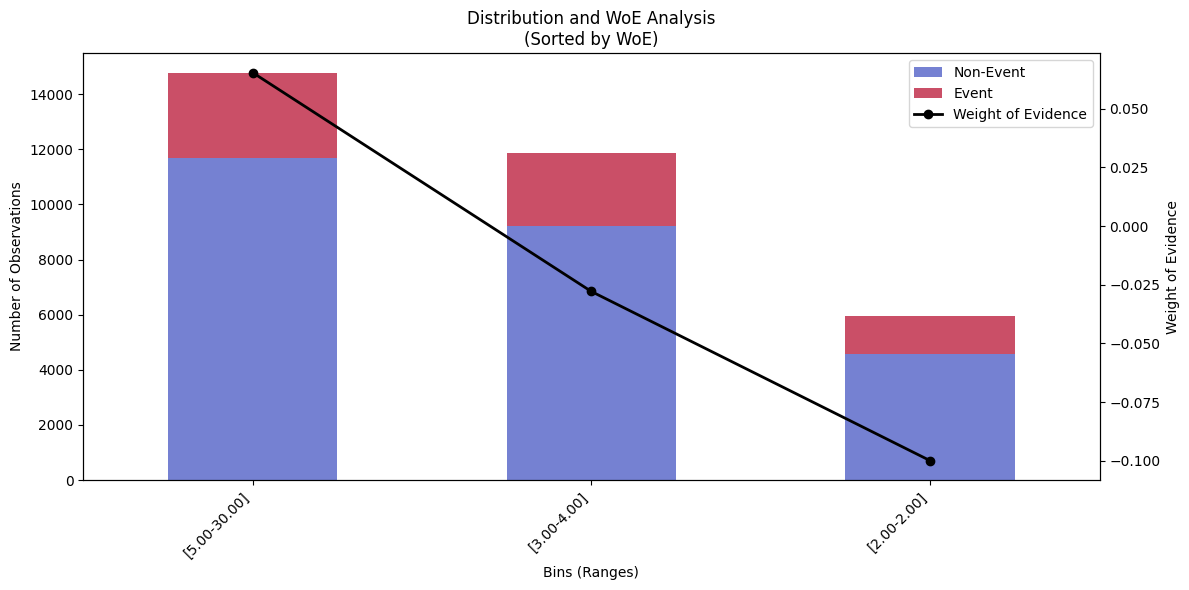

In [61]:
df, bin_stats, bin_labels = create_binned_feature(df, 'cb_person_cred_hist_length', 'loan_status', max_leaf_nodes=3)
df, woe_summary, iv = calculate_woe(df, 'cb_person_cred_hist_length', 'loan_status', plot=True, bin_labels=bin_labels)

In [66]:
cat_columns = df.select_dtypes(include=['object']).columns

def calculate_woe(col, df):
    crosstab_woe = pd.crosstab(df[col], df["loan_status"], normalize='columns')
    df[col + "_woe"] = df[col].map(np.log(crosstab_woe[0] / crosstab_woe[1]))

    return df

for col in cat_columns:
    df = calculate_woe(col, df)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   person_age                         32581 non-null  int64  
 1   person_income                      32581 non-null  int64  
 2   person_home_ownership              32581 non-null  object 
 3   person_emp_length                  32581 non-null  float64
 4   loan_intent                        32581 non-null  object 
 5   loan_grade                         32581 non-null  object 
 6   loan_amnt                          32581 non-null  int64  
 7   loan_int_rate                      32581 non-null  float64
 8   loan_status                        32581 non-null  int64  
 9   loan_percent_income                32581 non-null  float64
 10  cb_person_default_on_file          32581 non-null  object 
 11  cb_person_cred_hist_length         32581 non-null  int

#### Optimal binning

In [10]:
optbinner = OptimalBinning(name="loan_int_rate", dtype="numerical")

optbinner.fit(df['loan_int_rate'], df['loan_status'])

df['binned'] = optbinner.transform(df['loan_int_rate'], metric="bins")

bin_mapping = {bin_: f'Bin {i}' for i, bin_ in enumerate(natsorted(df['binned'].unique()))}
df['bin'] = df['binned'].map(bin_mapping)

df.groupby(['binned', 'bin'])['loan_int_rate'].agg(['min', 'max', 'mean', 'count']).sort_values(by='mean')

,,min,max,mean,count
binned,bin,,,,
"(-inf, 6.46)",Bin 0,5.42,6.39,5.828858,2084
"[6.46, 7.46)",Bin 1,6.54,7.43,6.942228,2531
"[7.46, 7.89)",Bin 2,7.49,7.88,7.634286,2569
"[7.89, 9.64)",Bin 3,7.90,9.63,8.730301,3186
"[9.64, 10.76)",Bin 4,9.64,10.75,10.300236,3645
"[10.76, 12.07)",Bin 5,10.78,12.04,11.248694,7426
"[12.07, 12.72)",Bin 6,12.09,12.72,12.461382,1831
"[12.72, 13.61)",Bin 7,12.73,13.61,13.216610,2891
"[13.61, 14.37)",Bin 8,13.62,14.35,14.052413,1662


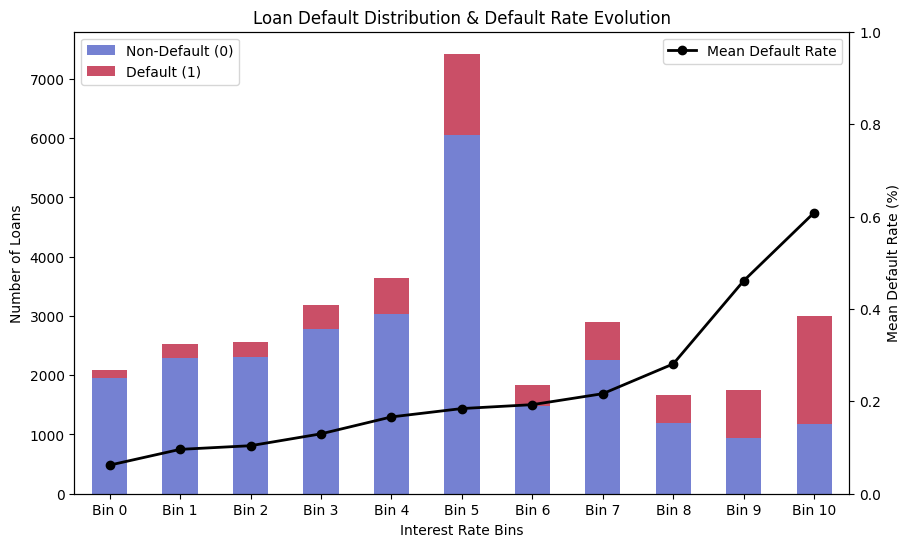

In [11]:
# Group by bins to count defaults vs. non-defaults
bin_counts = df.groupby(['bin', 'loan_status']).size().unstack(fill_value=0)

# Calculate mean default rate per bin
bin_default_rate = df.groupby('bin')['loan_status'].mean()

# Sort by bin order
bin_counts = bin_counts.loc[natsorted(bin_counts.index)]
bin_default_rate = bin_default_rate.loc[natsorted(bin_default_rate.index)]

# 🔹 PLOTTING 🔹
fig, ax1 = plt.subplots(figsize=(10, 6))

# Stacked bar plot for default & non-default counts
bin_counts.plot(kind='bar', stacked=True, ax=ax1, colormap="coolwarm", alpha=0.7)
ax1.set_xlabel("Interest Rate Bins")
ax1.set_ylabel("Number of Loans")
ax1.set_title("Loan Default Distribution & Default Rate Evolution")

# Create a second y-axis for default rate
ax2 = ax1.twinx()
ax2.plot(bin_default_rate.index, bin_default_rate.values, marker='o', color='black', linestyle='-', linewidth=2, label="Mean Default Rate")

ax2.set_ylabel("Mean Default Rate (%)")
ax2.set_ylim(0, 1)  # Default rate is between 0 and 1

# Show legend
ax1.legend(["Non-Default (0)", "Default (1)"], loc="upper left")
ax2.legend(loc="upper right")

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
plt.show()

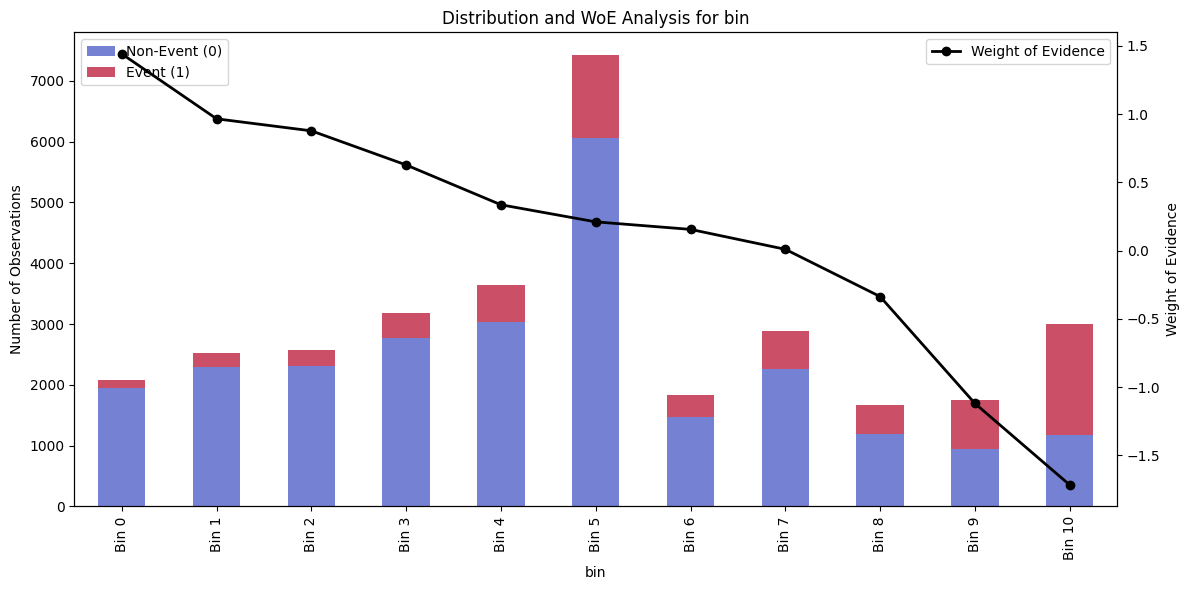

In [12]:
woe_summary, iv = metrics.calculate_woe(df, 'bin', 'loan_status', plot=True)